# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from lungpetctdx_dataset import LungPetCtDxDataset_TumorPresence
from utils.wandb import start_wandb_run, wandb_watch, wandb_log
from eval.reconstruction_viusalization import compare_images


cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pynvml module not found, please install pynvml'

# Defining datasets (train/validation) 

In [2]:
IMAGE_RESOLUTION = 128

In [3]:
from lungpetctdx_dataset import LungPetCtDxDataset_TumorPresence
from ct_dataset import NormalizationMethods
postprocess = transforms.Compose([
    transforms.Grayscale()
])
ds = LungPetCtDxDataset_TumorPresence(post_normalize_transform=postprocess,
    normalize=NormalizationMethods.SINGLE_IMAGE, cache=True)

trainSet, valSet = ds.subject_split(0.2)#random_split(ds, [0.8, 0.2])
dataloaders = {
    "val": torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=8),
    "train": torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=8),
}
num_classes = len(ds.class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
# model = torch.load("test")

# Defining model 

In [5]:
from capsule_net import CapsNet
from capsnet_config import Config

config = Config(
    cnn_in_channels=1,
    input_width=IMAGE_RESOLUTION,
    input_height=IMAGE_RESOLUTION,
    dc_in_channels=392,
    reconstruction_loss_factor=0.4,
    dc_num_capsules=num_classes,
    out_capsule_size=16,
    # Num labelled 0 tensor(5682)
    # Num labelled 1 tensor(47677)
    class_weights=torch.tensor([1., 5682/47677.]).to(device)
)

model = CapsNet(config)

start_wandb_run(config)

wandb_watch(model)
model.to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tfiedlerdev (7-vs-capsule). Use `wandb login --relogin` to force relogin


CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

# Setup training

In [6]:
from tqdm.notebook import tqdm
from utils.mask import mask_image

import numpy as np
def predicted_indices_from_outputs(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    _, max_length_indices = classes.max(dim=1)
    return torch.squeeze(max_length_indices, -1)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = []
    batchEnumeration = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_result = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_corrects = 0
            running_losses = np.array([0,0,0], np.float32)

            # Iterate over data.
            for idx, (inputs, labels, bounding_boxes) in enumerate(dataloaders[phase]):
               
                reconstruction_target_images = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))
                reconstruction_target_images = reconstruction_target_images.to(device)
            
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, reconstructions, _ = model(inputs)
                    preds = predicted_indices_from_outputs(outputs)
                    loss, classification_loss, reconstruction_loss = model.loss(reconstruction_target_images, outputs, labels, reconstructions, CEL_for_classifier=True)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_size = inputs.size(0)
                batch_loss = loss.item() * batch_size
                batch_classification_loss = classification_loss.item() * batch_size
                batch_reconstruction_loss = reconstruction_loss.item() * batch_size
                batch_losses = [batch_loss,batch_classification_loss, batch_reconstruction_loss]
                losses.append(batch_losses)
                batchEnumeration.append(batchEnumeration[-1]+1 if len(batchEnumeration)>0 else 0)

                running_losses += np.array(batch_losses)
                _, labels_index = torch.max(labels.data, 1)
                batch_num_correct = torch.sum(preds ==labels_index)
            
                running_corrects += batch_num_correct
                if idx % 10 == 0:
                    batch_size = inputs.size(0)
                    tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train acc: {:.6f}, batch loss: {:.6f}, running reconstr. loss: {:.6f}, running class. loss: {:.6f}".format(
                        epoch + 1,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        batch_num_correct / float(batch_size),
                        batch_loss, 
                        running_losses[2]/(idx+1), 
                        running_losses[1]/(idx+1)
                        ), end="\r")
                    
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_losses[0] / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]
            epoch_reconstruction_loss = running_losses[2] / dataset_sizes[phase]
            epoch_classification_loss =  running_losses[1]/ dataset_sizes[phase]

            epoch_result[phase] = {"acc": epoch_acc, "loss": epoch_loss, "classification_loss": epoch_classification_loss, "reconstruction_loss":epoch_reconstruction_loss}

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        wandb_log(epoch_result)
        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    figure, axis = plt.subplots(3)
    def plotLoss(lossIndex: int, title: str):
        axis[lossIndex].plot(batchEnumeration, [entry[lossIndex] for entry in losses])
        axis[lossIndex].set_title(title)
    
    for i, title in enumerate(["Combined Training losses", "Classification losses", "Reconstruction losses"]):
        plotLoss(i, title)
 

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [7]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

Epoch 0/0
----------


/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_2443291/716598704.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/torch/csrc/utils/tensor_new.cpp:230.)
  reconstruction_target_images = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))


train Loss: 0.4278 Acc: 0.58853], train acc: 0.718750, batch loss: 15.098934, running reconstr. loss: 9.519133, running class. loss: 4.1710771
val Loss: 0.3976 Acc: 0.5649668], train acc: 0.500000, batch loss: 11.331126, running reconstr. loss: 8.697827, running class. loss: 4.029356

Training complete in 74m 17s
Best val Acc: 0.564928


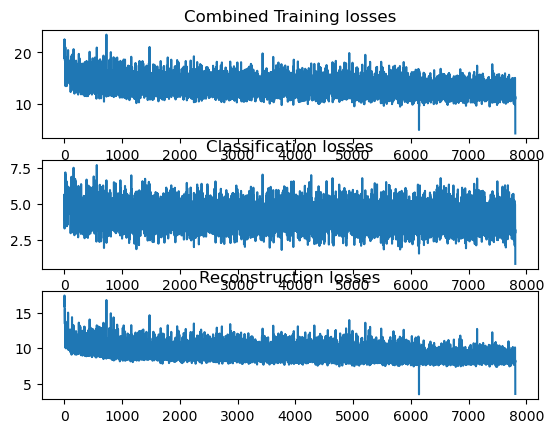

In [8]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

# Evaluation

Num labelled 0 tensor(5682)
Num labelled 1 tensor(47677)


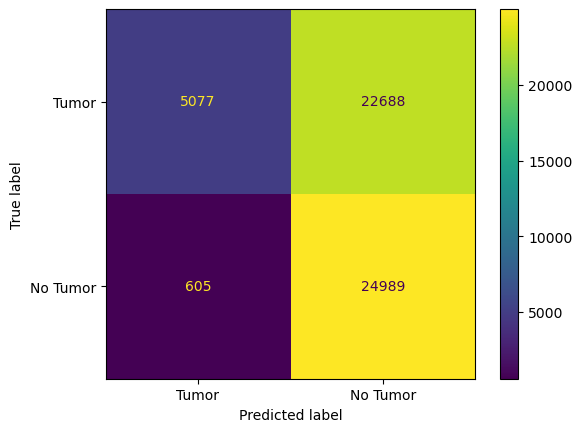

F1-score: 0.48514114997903157


In [9]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

num_labelled_1 = 0
num_labelled_0 = 0
y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
        x = np.unique(classes, axis=0)
        if len(x) < 2:
            pass
            #print("Skip!")
            # continue
        _, classIndices = torch.max(classes.cpu(), 1)

        num_labelled_1 += classIndices.sum()
        num_labelled_0 += classIndices.size()[0]-classIndices.sum()
    
        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs, _, _ = model(inputs)
        
        
        preds = predicted_indices_from_outputs(outputs).cpu()
        _, labels = torch.max(classes.cpu(), 1)
    
        y_true = np.concatenate((y_true, preds))
        y_pred = np.concatenate((y_pred, labels))

print("Num labelled 0", num_labelled_0)
print("Num labelled 1", num_labelled_1)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=ds.class_names)
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

In [10]:
ds.class_names

['Tumor', 'No Tumor']

# Visualize reconstruction samples


/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Inputs min -1.7801649570465088 max 25.78399085998535 mean 0.0005500726401805878 std 0.9853324890136719
reconstruction_targets min -1.7801649570465088 max 25.78399085998535 mean -0.051097575575113297 std 0.9761725664138794
reconstructions min 8.05665485281294e-22 max 1.0 mean 0.19808006286621094 std 0.367154061794281
inputs shape torch.Size([32, 1, 128, 128])
reconstructions shape torch.Size([32, 1, 128, 128])


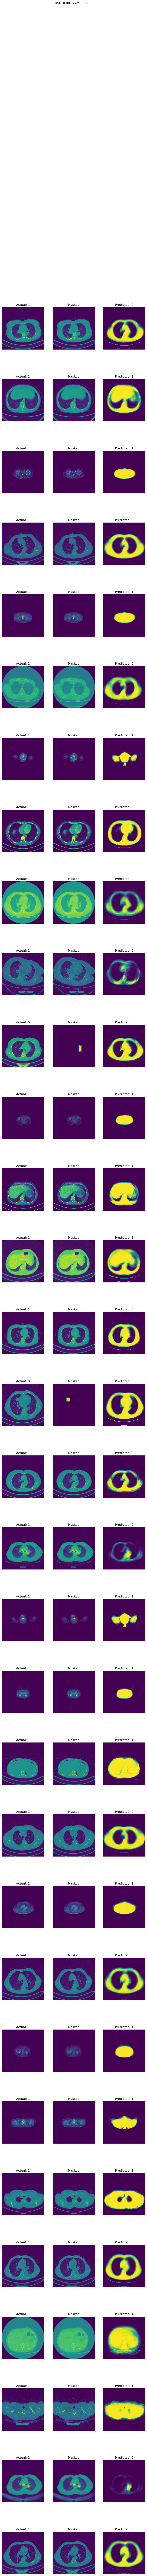

In [11]:
with torch.no_grad():
    
    inputs, classes, bounding_boxes = next(iter(dataloaders['val']))
    reconstruction_targets = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))
    reconstruction_targets = reconstruction_targets.to(device)
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs, reconstructions, _ = model(inputs)
    preds = predicted_indices_from_outputs(outputs).cpu()
    _, labels = torch.max(classes.cpu(), 1)

    print("Inputs min",inputs.min().item(), "max", inputs.max().item(), "mean", inputs.mean().item(), "std", inputs.std().item())
    print("reconstruction_targets min",reconstruction_targets.min().item(), "max", reconstruction_targets.max().item(), "mean", reconstruction_targets.mean().item(), "std", reconstruction_targets.std().item())
    print("reconstructions min",reconstructions.min().item(), "max", reconstructions.max().item(), "mean", reconstructions.mean().item(), "std", reconstructions.std().item())
    print("inputs shape", inputs.size())
    print("reconstructions shape", reconstructions.size())
    compare_images([(inputs[i], reconstruction_targets[i],reconstructions[i]) for i in range(reconstructions.size(0))], preds, labels)

In [12]:

reconstructions[0].min()


tensor(1.0840e-09, device='cuda:0')

In [13]:
inputs[1:4]

tensor([[[[-0.9033, -0.8595, -0.8423,  ..., -0.8523, -0.8629, -0.8623],
          [-0.8606, -0.8385, -0.8495,  ..., -0.8651, -0.8529, -0.8562],
          [-0.8529, -0.8385, -0.8490,  ..., -0.8490, -0.8617, -0.8568],
          ...,
          [-0.8279, -0.8124, -0.8107,  ..., -0.8268, -0.8407, -0.8318],
          [-0.8529, -0.8196, -0.8196,  ..., -0.8263, -0.8507, -0.8357],
          [-0.9033, -0.8573, -0.8285,  ..., -0.8390, -0.8301, -0.8379]]],


        [[[-0.2481, -0.2481, -0.2481,  ..., -0.2481, -0.2481, -0.2481],
          [-0.2481, -0.2481, -0.2481,  ..., -0.2481, -0.2481, -0.2481],
          [-0.2481, -0.2481, -0.2481,  ..., -0.2481, -0.2481, -0.2481],
          ...,
          [-0.2481, -0.2481, -0.2481,  ..., -0.2481, -0.2481, -0.2481],
          [-0.2481, -0.2481, -0.2481,  ..., -0.2481, -0.2481, -0.2481],
          [-0.2481, -0.2481, -0.2481,  ..., -0.2481, -0.2481, -0.2481]]],


        [[[-0.8424, -0.8424, -0.8424,  ..., -0.8424, -0.8424, -0.8424],
          [-0.8424, -0.842

# Count classes

In [14]:
numClass0 = 0
numClass1 = 0

for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
# for i, (inputs, classes) in enumerate(dataloaders['val']):
    #_, labels = torch.max(classes.cpu(), 1)
    #batchNum1 = torch.sum(labels)
    #numClass1 += batchNum1
    #numClass0 += len(labels)-batchNum1
    print(inputs.size())
    break

print("Samples of class 0: ", numClass0)
print("Samples of class 1: ", numClass1)


torch.Size([32, 1, 128, 128])
Samples of class 0:  0
Samples of class 1:  0


# Explain Model Performance
Using SHAP

In [15]:
inputs[1:4]

tensor([[[[-0.7640, -0.7640, -0.7640,  ..., -0.7640, -0.7640, -0.7640],
          [-0.7640, -0.7640, -0.7640,  ..., -0.7640, -0.7640, -0.7640],
          [-0.7640, -0.7640, -0.7640,  ..., -0.7640, -0.7640, -0.7640],
          ...,
          [-0.7640, -0.7640, -0.7640,  ..., -0.7640, -0.7640, -0.7640],
          [-0.7640, -0.7640, -0.7640,  ..., -0.7640, -0.7640, -0.7640],
          [-0.7640, -0.7640, -0.7640,  ..., -0.7640, -0.7640, -0.7640]]],


        [[[-0.5637, -0.5637, -0.5637,  ..., -0.5637, -0.5637, -0.5637],
          [-0.5637, -0.5637, -0.5637,  ..., -0.5637, -0.5637, -0.5637],
          [-0.5637, -0.5637, -0.5637,  ..., -0.5637, -0.5637, -0.5637],
          ...,
          [-0.5637, -0.5637, -0.5637,  ..., -0.5637, -0.5637, -0.5637],
          [-0.5637, -0.5637, -0.5637,  ..., -0.5637, -0.5637, -0.5637],
          [-0.5637, -0.5637, -0.5637,  ..., -0.5637, -0.5637, -0.5637]]],


        [[[-0.4514, -0.4514, -0.4514,  ..., -0.4514, -0.4514, -0.4514],
          [-0.4514, -0.451

In [16]:
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

transform= [
    # torchvision.transforms.Lambda(nhwc_to_nchw),
    # torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [17]:
import shap

inputs, classes, bounding_boxes = next(iter(dataloaders['train']))
inputs = transform(inputs)

def predict(img_batch):
    # print(f'Predict {img_batch.shape}')
    # print(img_batch.shape)
    img_batch = nhwc_to_nchw(torch.tensor(img_batch))
    is_single = False
    if img_batch.shape[0] == 1:
        is_single = True
        img_batch = img_batch.repeat(2,1,1,1)
    # print(is_single)
    # print(img_batch.shape)
    img_batch = img_batch.to(device)
    output, _, _ = model(img_batch)
    if is_single:
        output = output[0:1, :]
    output = softmax_output(output)
    # print(output.shape)
    return output.detach().cpu()


def softmax_output(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    output = torch.nn.Softmax(dim=1)(classes)
    return np.squeeze(output.detach().cpu(), -1)

ModuleNotFoundError: No module named 'shap'

In [ ]:
num_classes

In [ ]:
# Based on https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

n_top_prediction = len(ds.class_names)
n_evals = 50000
# define a masker that is used to mask out partitions of the input image.
# masker_blur = shap.maskers.Image("blur(128,128)", inputs[0].shape)

# create an explainer with model and image masker
masker = shap.maskers.Image("blur(32, 32)", inputs[0].shape)
explainer = shap.Explainer(predict, masker=masker, output_names=ds.class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
input_images = inputs[:10].cpu().numpy()
# print(input_images.shape)
shap_values = explainer(input_images, max_evals=n_evals, batch_size=inputs.shape[0], outputs=shap.Explanation.argsort.flip[:2])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
shap.image_plot(shap_values)

In [ ]:
torch.save(model, "test")